# Auswertung - Genauigkeit der Daten

In diesem ersten Abschnitt soll die tatsächlich Treff - Genauigkeit untersucht werden. Dabei steht die Frage im Raum, wo die Blicke primär in der Küche auftreffen und in wie weit diese von dem eigentlich zu Treffenden Ziel Abweichen.

Zusammenfassung: https://docs.google.com/document/d/1cZ68-ooXPYZ2aMFKG56UbjXHML7n7P86LF8aBbHDcb0/edit?usp=sharing

## Auswertungs-Fragen:
* [Frage 1: X](#cell1)

## Ablauf:
1. Importieren der benötigten Bibliotheken
2. Definition der AOIs
3. Definition der Auswertefunktion
4. Definition zum Einlesen der Transformationsmatrizenwerte
5. Dateipfade einlesen (Abgabeverzeichnis 1_Daten/2_processed)
6. Definition der zu analysierenden Daten (AOI, Person, etc.)
7. Auswertung ausführen

In [66]:
# Schritt 1: Importieren der benötigten Bibliotheken

import sys
import os
import pandas as pd
import numpy as np
import math
import json
from ipywidgets import interactive, IntSlider, FloatSlider
sys.path.append('lib')
from helper import AOI
from helper import Intersection
from helper import translate, rotate_x, rotate_y, rotate_z, scale_x, scale_y, scale_z
from helper import plot, plot_with_image, plot_vectors, plot_vectors_with_image, plot_vectors_with_image_and_aois, plot_heatmap
from helper import apply_transformation, normalize, get_all_aois_intersection, set_closest_intersection_and_get_distance, get_gaze_pairs

In [107]:
# Schritt 2:  Definition der AOIs

def get_aois():
    test = {
        "cross_hair_x": 0,
        "cross_hair_y": 0,
        "cross_hair_z": 0
    }
    schrank_oben = AOI([0, 330, 75], [800, 330, 75], [0, 496, 75], test, 'orange', 'Schrank oben')
    wand = AOI([0, 330, 1], [0, 200, 1], [800, 330, 1], test, 'blue', 'Wand zwischen Schränken')
    schrank_unten = AOI([0, 200, 156], [800, 200, 156], [0, 0, 156], test, 'white', 'Schrank unten')
    af = AOI([0, 200, 0], [800, 200, 0], [0, 200, 156], test, 'green', 'Arbeitsfläche')
    ks = AOI([800, 0, 156], [935, 0, 156], [800, 496, 156], test, 'cyan', 'Kühlschrank')
    
    # TODO: ADD ALL 26 AOIs
    
    return [schrank_oben, wand, schrank_unten, ks, af]

In [108]:
# Schritt 3:  Definition der Auswertefunktion

def run_aoi_evaluation(aois, transformation_matrix, coordinates, gazes, heatmap_prefix):
    # normierte Blickrichtung auf Startkoordinaten addieren
    gaze_ends = np.swapaxes(np.swapaxes(coordinates, 0, 1) + np.swapaxes(gazes, 0, 1) * 10000, 0, 1)

    # transformieren
    transformed_coordinates = apply_transformation(coordinates, transformation_matrix, swap=False)
    transformed_gaze_ends = apply_transformation(gaze_ends, transformation_matrix, swap=False)

    # Blickrichtung zurückrechnen und normalisieren
    transformed_directions = transformed_gaze_ends - transformed_coordinates
    transformed_gazes = np.array([normalize(transformed_directions[i]) for i in range(len(transformed_directions))])

    # Intersektion Ojekte erstellen
    intersections = get_all_aois_intersection(transformed_coordinates, transformed_gazes, aois)

    # Kürzeste Entfernung für jeden Punkt
    distances = np.array([set_closest_intersection_and_get_distance(intersections[i]) for i in range(len(intersections))])

    # Start- und Endpunkte der Blicke (Start = Ende, wenn kein Schnittpunkt => Entfernung INF)
    gaze_starts, gaze_ends = get_gaze_pairs(transformed_coordinates, transformed_gazes, distances)

    gaze_starts = np.swapaxes(gaze_starts, 0, 1)
    gaze_ends = np.swapaxes(gaze_ends, 0, 1)

    plot_vectors(gaze_starts, gaze_ends, 'Test')
    plot_vectors_with_image_and_aois(gaze_starts, gaze_ends, aois, 'Test')

    for aoi in aois:
        plot_heatmap(aoi, aoi.title, save=False, filename='%s%s.png' % (heatmap_prefix, aoi.title))
        

In [109]:
# Schritt 4: Definition zum Einlesen der Transformationsmatrizenwerte

filename = "transformation_matrix/cam_config.json"
matrix_cache = {
    "cam_1": None,
    "cam_2": None,
    "cam_3": None,
    "cam_4": None
}

def fill_matrix_cache():
    with open(filename, 'r') as f:
        config = json.load(f)
        matrix_cache["cam_1"] = get_transformation_matrix("cam_1", config["cam_1"])
        matrix_cache["cam_2"] = get_transformation_matrix("cam_2", config["cam_2"])
        matrix_cache["cam_3"] = get_transformation_matrix("cam_3", config["cam_3"])
        matrix_cache["cam_4"] = get_transformation_matrix("cam_4", config["cam_4"])

def get_transformation_matrix(client_id, config):     
    rot_x = rotate_x(math.radians(config["rot_x"]))
    rot_y = rotate_y(math.radians(config["rot_y"]))
    rot_z = rotate_z(math.radians(config["rot_z"]))

    s_x = scale_x(config["s_x"])
    s_y = scale_y(config["s_y"])
    s_z = scale_z(config["s_z"])

    d = translate(config["t_x"], config["t_y"], config["t_z"])
    
    return scale_x(-1) @ rotate_y(math.radians(-90)) @ d @ s_z @ s_y @ s_x @ rot_z @ rot_y @ rot_x @ scale_y(-1)


fill_matrix_cache()

In [110]:
# Schritt 5: Dateipfade einlesen 

# siehe https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python

root = '../0_annotation/test'
FILE_NAMES = []

for subdir, dirs, files in os.walk(root):
    for file in files:
        if '02__annotation' not in file or '.csv' not in file:
            continue
        FILE_NAMES.append(os.path.join(subdir, file).replace('\\', '/'))

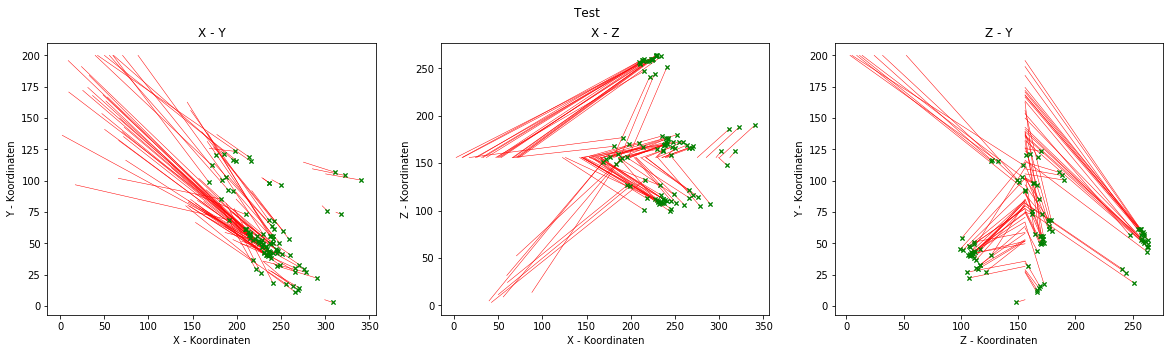

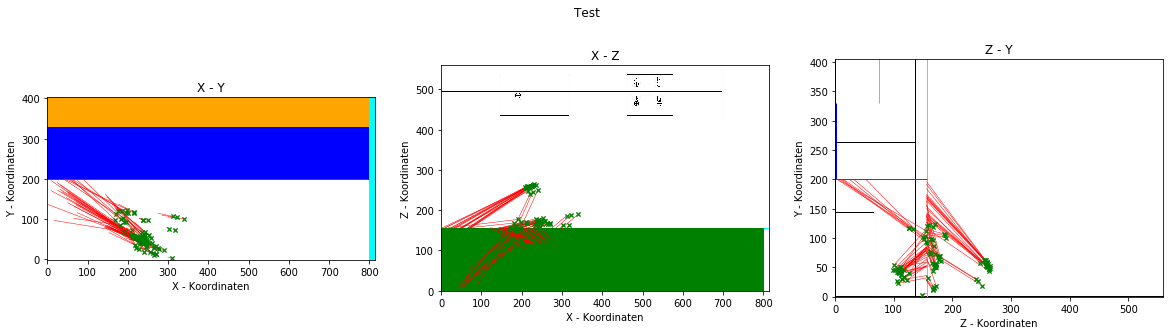

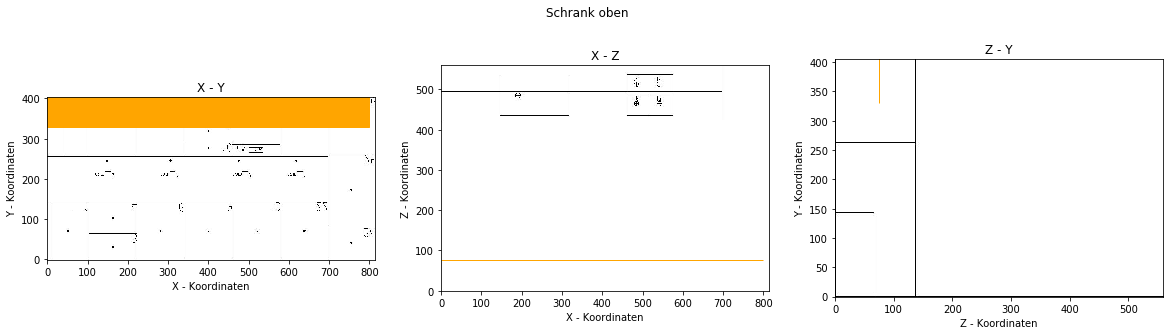

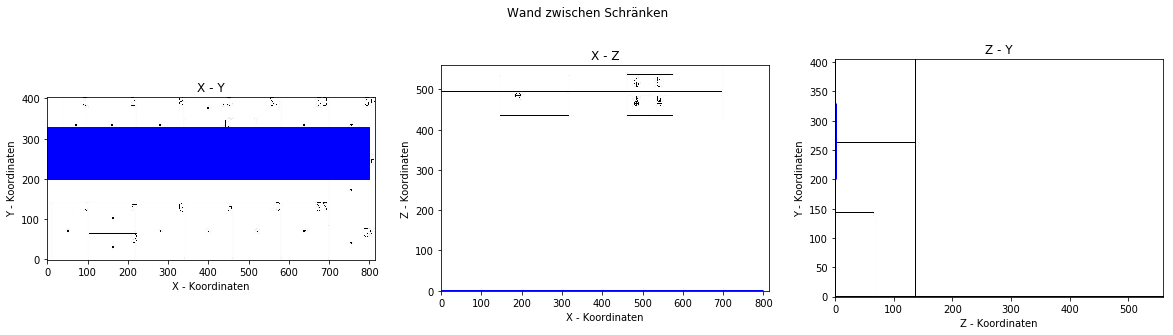

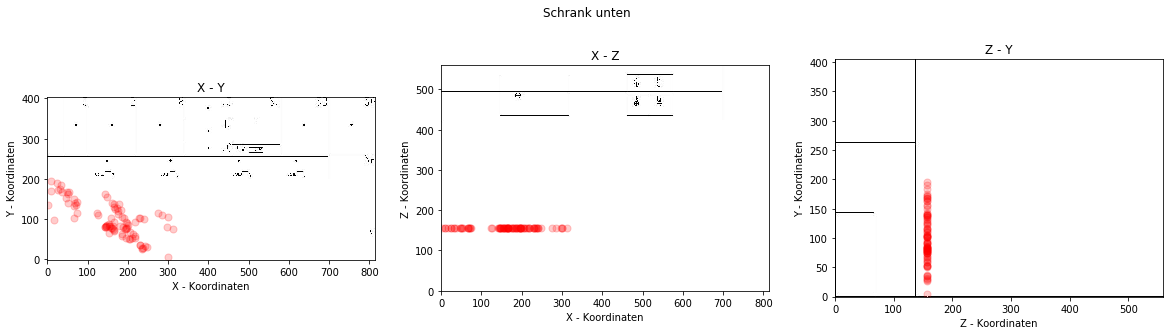

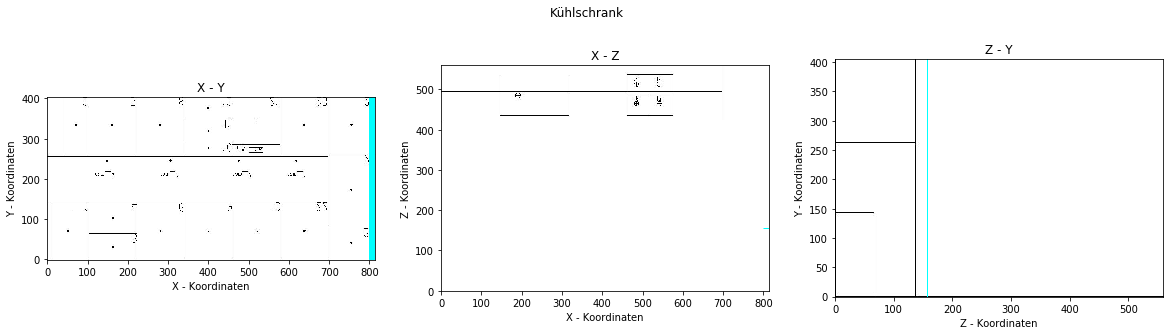

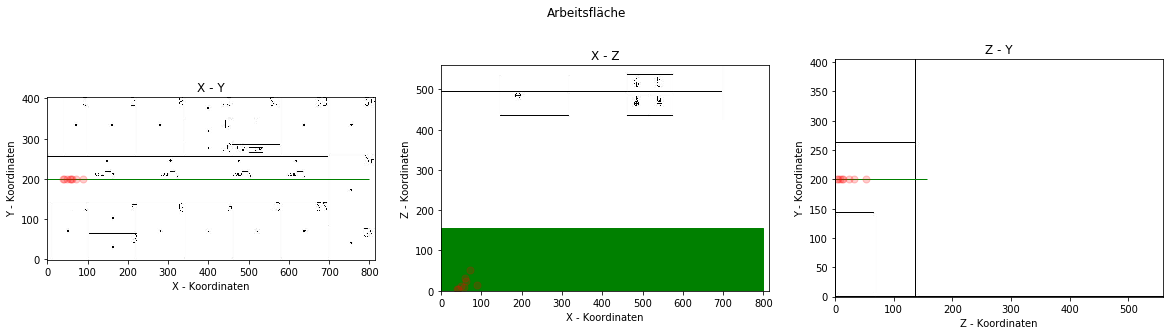

In [111]:
# Schritt 6: Definition der zu analysierenden Daten (AOI, Person, etc.)

for f in FILE_NAMES:
    df = pd.read_csv(f, sep=',', engine='python')
     
    coords = np.array([df['eye_lmk_X_0'], df['eye_lmk_Y_0'], df['eye_lmk_Z_0']])
    gazes = np.array([df['gaze_direction_1_x'], df['gaze_direction_1_y'], df['gaze_direction_1_z']])
                    
    run_aoi_evaluation(get_aois(), matrix_cache['cam_1'], coords, gazes, 'results')